In [0]:
# Importing Libraries
from __future__ import absolute_import, division, print_function, unicode_literals 
import pandas as pd 
import numpy as np 

import seaborn as sn 
from seaborn import distplot

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
 
# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split




In [0]:
# Getting Filepath of the data
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
# Reading data 
raw_data = pd.read_csv(filepath)

In [0]:
# Displaying the upper portion of data
raw_data.head

<bound method NDFrame.head of                                 CONS_NO  FLAG  ...  2016-10-30  2016-10-31
0      0387DD8A07E07FDA6271170F86AD9151     1  ...    9.160000    6.740000
1      01D6177B5D4FFE0CABA9EF17DAFC2B84     1  ...    0.000000    0.000000
2      4B75AC4F2D8434CFF62DB64D0BB43103     1  ...   13.483126   13.483126
3      B32AC8CC6D5D805AC053557AB05F5343     1  ...   14.460000   11.720000
4      EDFC78B07BA2908B3395C4EB2304665E     1  ...    9.860000    8.720000
...                                 ...   ...  ...         ...         ...
42367  F1472871E1AFF49D4289564B6377D76C     0  ...    3.590000    2.540000
42368  F3C8BBCD2DC26C1E0249DEEF6A4256B7     0  ...    6.050000    4.770000
42369  A9A0FE83467A680FBFB0DBFC910DF227     0  ...    0.390000    0.650000
42370  D9A6ADA018FA46A55D5438370456AA45     0  ...   13.330000   10.390000
42371  F3406636BAD1E6E0826E8EDDC9A1BF00     0  ...    7.160000    5.250000

[42372 rows x 1036 columns]>

In [0]:
# Column 2 onwards are kWhs, column 1 is the FLAG
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [0]:
# Extracting number of rows and columns in the feature matrix
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


In [0]:
# FUnction to sacle data
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

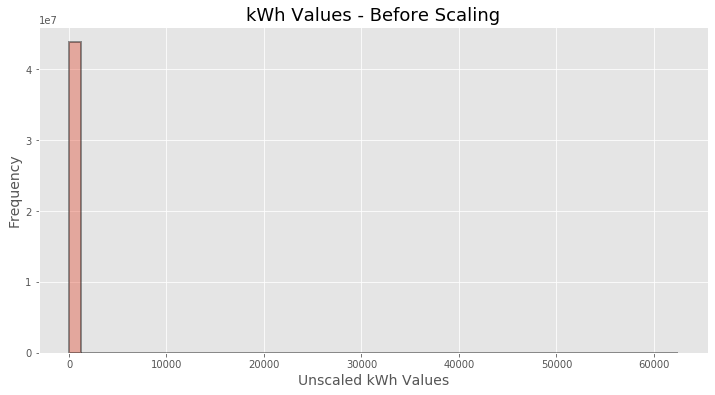

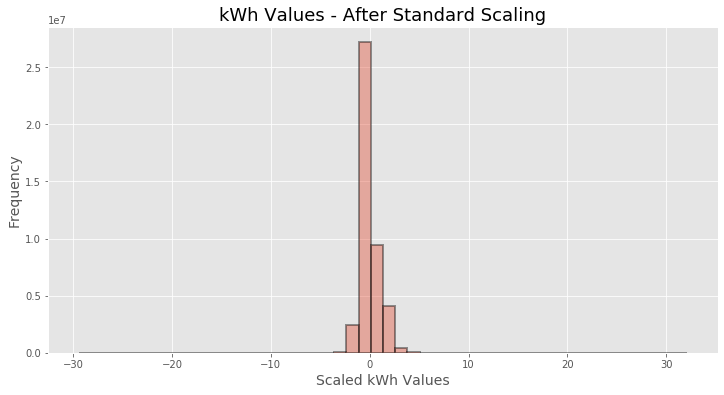

In [0]:
# Scaling data using standard scaling
X_scaled_std = scale_features(X=kWhs,scaling_strategy='Standard', plot_distributions=True)

In [0]:
# Printing dimension of datatset for padding
NUM_DAYS = 1034
DAYS_PER_WEEK = 7
NUM_WEEKS_FLOAT = NUM_DAYS / DAYS_PER_WEEK 
NUM_WEEKS = int(np.ceil(NUM_WEEKS_FLOAT))
print(f"Number of days per dataset: {NUM_DAYS}.\nNumber of days per week: {DAYS_PER_WEEK}")
print(f"So exact number of weeks: {NUM_WEEKS_FLOAT}\nWhich, when rounded up is {NUM_WEEKS}")
print(f"Which means new number of days is: {NUM_WEEKS * DAYS_PER_WEEK}")
print(f"Extra days to add: {NUM_WEEKS * DAYS_PER_WEEK - NUM_DAYS}")

Number of days per dataset: 1034.
Number of days per week: 7
So exact number of weeks: 147.71428571428572
Which, when rounded up is 148
Which means new number of days is: 1036
Extra days to add: 2


In [0]:
# 2 extra days per consumer 
X_scaled_std_padded = np.append(X_scaled_std, np.zeros((NUM_CONSUMERS, 2)), 
                                axis=1)

In [0]:
# Does it have the right shape?
X_scaled_std_padded.shape

(42372, 1036)

In [0]:
# Are the last two columns (and only the last two columns) zero?
pd.DataFrame(X_scaled_std_padded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,...,0.063220,0.561141,0.028722,0.106917,0.284007,0.265608,-0.005776,1.212002,0.377151,0.432348,1.410940,0.350703,0.178213,-0.101220,-0.102370,-0.172516,-0.132269,0.049421,0.036771,0.133366,-0.032224,0.467996,0.387501,0.060920,-0.036824,-0.108120,0.100018,-0.154117,-0.054073,0.048271,0.050571,0.216161,-0.249562,0.126466,0.189712,-0.012676,0.173613,-0.104670,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,...,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,1.440577,2.639282,2.639282,2.639282,2.639282,2.463751,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.048888,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,0.0,0.0
3,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,...,0.207467,1.742458,0.823156,1.524534,0.022337,0.391539,1.301320,1.110901,2.171960,0.889803,1.032617,1.884215,0.671879,0.482517,0.579842,0.713136,0.631679,0.991360,0.755451,0.924713,0.880282,0.812577,0.928945,0.827388,0.897208,0.574553,0.575611,0.602058,0.689863,0.934234,1.160621,0.912018,1.407109,1.534055,1.233616,1.372199,0.864414,0.574553,0.0,0.0
4,-1.095170,-0.485963,-0.185806,-1.001788,-0.937310,-0.550441,-0.688291,-0.921746,-0.955097,-0.979554,-0.892842,-0.721642,-0.948427,-0.795013,-0.881725,-0.955097,-0.981778,-1.550963,-1.544293,-0.892842,-0.292529,0.303338,-0.007936,-0.179136,-0.127999,-0.323656,-0.310316,0.014298,-0.081308,0.027638,-0.052404,-0.663834,-0.392581,-0.494857,-0.245838,-0.119105,-0.494857,-0.343667,-0.243614,-0.190253,...,0.616835,0.496772,0.659079,0.685760,2.211000,0.565697,1.263839,1.401689,2.137628,1.808568,0.968129,2.382201,1.248275,0.856960,0.294444,0.296668,0.525676,0.552357,0.045425,0.501219,0.559027,0.759131,1.626250,1.452827,1.014820,0.563473,0.325572,0.018745,1.419476,0.532346,0.1432

In [0]:
# Creating a new numpy array to store the training dat
X_reshaped = np.zeros((NUM_CONSUMERS, NUM_WEEKS, DAYS_PER_WEEK,1))

In [0]:
def transform_daily_to_weekly(daily_kWhs):
  """Will simply reshape the 1D daily kWhs of a single consumer into 2D weekly data""" 
  return daily_kWhs.reshape(NUM_WEEKS, DAYS_PER_WEEK, 1)

In [0]:
# Applying this function to every consumer in the original dataset
# And saving the (148, 7) kWhs matrix for that consumer at the ith index in 3D array
for i in range(0, NUM_CONSUMERS):
  X_reshaped[i] = transform_daily_to_weekly(X_scaled_std_padded[i])

In [0]:
print(X_reshaped.shape)
X_reshaped[1]


(42372, 148, 7, 1)


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [0]:
# Loading Data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=labels)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33897, 148, 7, 1) (8475, 148, 7, 1) (33897,) (8475,)


In [0]:
def build_model():
  model = Sequential()

  #First conv layer
  model.add(Conv2D(filters = 18, kernel_size = (3,3), activation = 'tanh', input_shape = (148,7,1), padding ='same'))
  #model.add(MaxPooling2D(pool_size = (7,7)))

  #second conv layer
  model.add(Conv2D(filters = 36, kernel_size = (3,3), activation = 'tanh',padding ='same')) 
  #model.add(MaxPooling2D(pool_size = (7,7)))

  #Third conv layer
  model.add(Conv2D(filters = 72, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  #model.add(MaxPooling2D(pool_size = (7,7)))

  #Fourth conv layer
  model.add(Conv2D(filters = 144, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  #model.add(MaxPooling2D(pool_size = (7,7)))


  #Fifth conv layer
  model.add(Conv2D(filters = 288, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  
  #Max Pooling Layer
  model.add(MaxPooling2D(pool_size = (3,3)))

  # Fully Connected layer
  model.add(Flatten())
  model.add(Dense(units=60, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))


  # Compile with reasonable defaults for this problem
  model.compile(optimizer='sgd', 
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()]
                  )
  
  return model

In [0]:
model = build_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 7, 36)        5868      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 7, 72)        23400     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 7, 144)       93456     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 7, 288)       373536    
_________________________________________________________________
max_pooling2d

In [0]:
# Fit the model, remember its training history
history = model.fit(X_train, y_train, 
                             batch_size=128, epochs=20,
                             validation_split=0.2, verbose = 1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 19s 685us/sample - loss: 0.3029 - auc: 0.5767 - val_loss: 0.2907 - val_auc: 0.6130
Epoch 2/20
27117/27117 [==============================] - 11s 404us/sample - loss: 0.2809 - auc: 0.6382 - val_loss: 0.2829 - val_auc: 0.6690
Epoch 3/20
27117/27117 [==============================] - 11s 404us/sample - loss: 0.2755 - auc: 0.6756 - val_loss: 0.2789 - val_auc: 0.6951
Epoch 4/20
27117/27117 [==============================] - 11s 402us/sample - loss: 0.2713 - auc: 0.6987 - val_loss: 0.2775 - val_auc: 0.7178
Epoch 5/20
27117/27117 [==============================] - 11s 404us/sample - loss: 0.2681 - auc: 0.7132 - val_loss: 0.2742 - val_auc: 0.7165
Epoch 6/20
27117/27117 [==============================] - 11s 402us/sample - loss: 0.2652 - auc: 0.7240 - val_loss: 0.2698 - val_auc: 0.7316
Epoch 7/20
27117/27117 [==============================] - 11s 402us/sample - loss: 0.2623 - auc: 0.7331 -

In [0]:
# plotting function
def generate_train_val_plot(epochs, train_data, val_data, metric, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_data, 'b', label='Training ' + metric)
    plt.plot(epochs, val_data, 'r', label='Validation ' + metric)
    plt.grid(); plt.xlabel('Epochs'); plt.ylabel(metric); plt.legend()
    plt.title('Training vs Validation ' + metric + ' - ' + model_name)

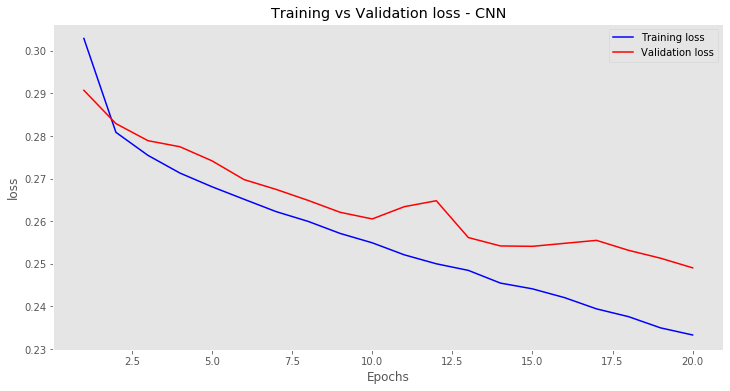

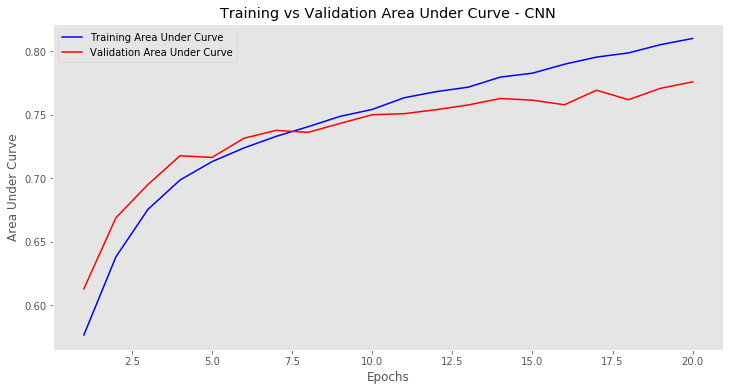

In [0]:
#Plotting 
    history = history.history
    epochs = list(range(1, 21))
    loss = history['loss']
    val_loss = history['val_loss']
    auc = history['auc']
    val_auc = history['val_auc']
    generate_train_val_plot(epochs, loss, val_loss, 'loss', model_name='CNN')
    generate_train_val_plot(epochs, auc, val_auc, 'Area Under Curve', model_name='CNN')

# Training on Test Data

In [0]:
history_test = model.predict(X_test)

In [0]:
#Plotting 
    history = history_test.history
    epochs = list(range(1, 21))
    loss = history['loss']
    val_loss = history['val_loss']
    auc = history['auc']
    val_auc = history['val_auc']
    generate_train_val_plot(epochs, loss, val_loss, 'loss', model_name='CNN')
    generate_train_val_plot(epochs, auc, val_auc, 'Area Under Curve', model_name='CNN')

In [71]:
history_test[40]

array([0.70329154], dtype=float32)

In [70]:
np.argwhere(history_test > 0.45)

array([[  40,    0],
       [  66,    0],
       [ 151,    0],
       [ 266,    0],
       [ 439,    0],
       [ 465,    0],
       [ 474,    0],
       [ 511,    0],
       [ 532,    0],
       [ 779,    0],
       [ 892,    0],
       [ 989,    0],
       [1037,    0],
       [1066,    0],
       [1192,    0],
       [1201,    0],
       [1239,    0],
       [1514,    0],
       [1556,    0],
       [1614,    0],
       [1681,    0],
       [1750,    0],
       [1919,    0],
       [1945,    0],
       [2283,    0],
       [2305,    0],
       [2314,    0],
       [2321,    0],
       [2324,    0],
       [2402,    0],
       [2581,    0],
       [2609,    0],
       [2649,    0],
       [2657,    0],
       [2843,    0],
       [2866,    0],
       [2916,    0],
       [2945,    0],
       [3137,    0],
       [3167,    0],
       [3196,    0],
       [3229,    0],
       [3327,    0],
       [3423,    0],
       [3563,    0],
       [3826,    0],
       [3875,    0],
       [4003,

In [59]:
y_test

32374    0
26979    0
22576    0
15932    0
32163    0
        ..
16283    0
41731    0
18609    0
23664    0
15260    0
Name: FLAG, Length: 8475, dtype: int64

In [58]:
print(y_test[y_test == 1].index.values)

[2669 3357  239 1663 1297 2865  761 3181 2234 3381 2148 1550  531 2068
 1416 3603 3096 1316 2763 1583 3020  424  221 2469 1104 2522  819 2393
 1157 3257 1869  666 2239  778 2404  228  521 1397 1247 1728 3094  772
 2110 2948  670 3389 1772  912 2091 2685 3245 2510 3511 1394 3468 2737
 1052 3217 3470  317 1167  878 1710 1090 2434 2756  129 3497 3450 2207
 2341 1628 2255 1961 1366 2302 1298  434 1422  390 2861 2400 1481 1609
 1793 2874 1966 3406 2508 1852 2355  320 3002 1036  455 1725 2931 1812
 1985 2052 1342 2591 1547 2918 3453 2356 1060 1945 1326 2465  715 3475
 1044 3143 3242  427  298 2074 1858 1120 3321 3005   11  822 3164 3281
 1749 1217 2198  632 3256 2729 2536 2220 2611 1978  987  679   63 3441
 2483 3131 2800 2566  582 2544 1953 2231 2480 2490 2955 1321  720 2245
  907 2042  494 3572 2150  888 1863 2822  446 1447 1508  953 3276 2163
 1560 2584 3486 3438 3249 1783 1847 2125 1938  342  499 1645 1096 1471
  810 2063 3089  859 1811 1780  208  965 2602 1567 2607 2646  483 3123
 3311 

In [0]:
y_test.sort_index(inplace=True)

In [61]:
y_test

11       1
22       1
26       1
28       1
35       1
        ..
42340    0
42341    0
42347    0
42352    0
42369    0
Name: FLAG, Length: 8475, dtype: int64